In [1]:
import time, os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from get_dataset import load_dataset
from get_dataset import get_trainset
from get_dataset import scaler_user
from embedding import embedding_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
created_time = int(time.time()) 
user_dataset = load_dataset('user')
chest_list, chest_dataset = load_dataset('exercise')
user_dataset = scaler_user(user_dataset)

num_chest_dataset = len(chest_dataset[0])
num_user_dataset = len(user_dataset[0])

user_train_input, chest_train_input, chest_label = get_trainset(user_dataset, chest_list, chest_dataset)
print(np.shape(user_train_input),np.shape(chest_train_input),chest_label)

x_train, x_val, y_train, y_val, label_train, label_val = train_test_split(user_train_input, chest_train_input, chest_label, test_size=0.2, random_state=2022)

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(label_train))

(1500000, 6) (1500000,) [0 0 0 ... 0 0 1]
(1200000, 6)
(1200000,)
(1200000,)


KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='multiply/mul:0', description="created by layer 'multiply'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 6)         96          ['item_input[0][0]']             
                                                                                                  
 user_unput (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 6)      

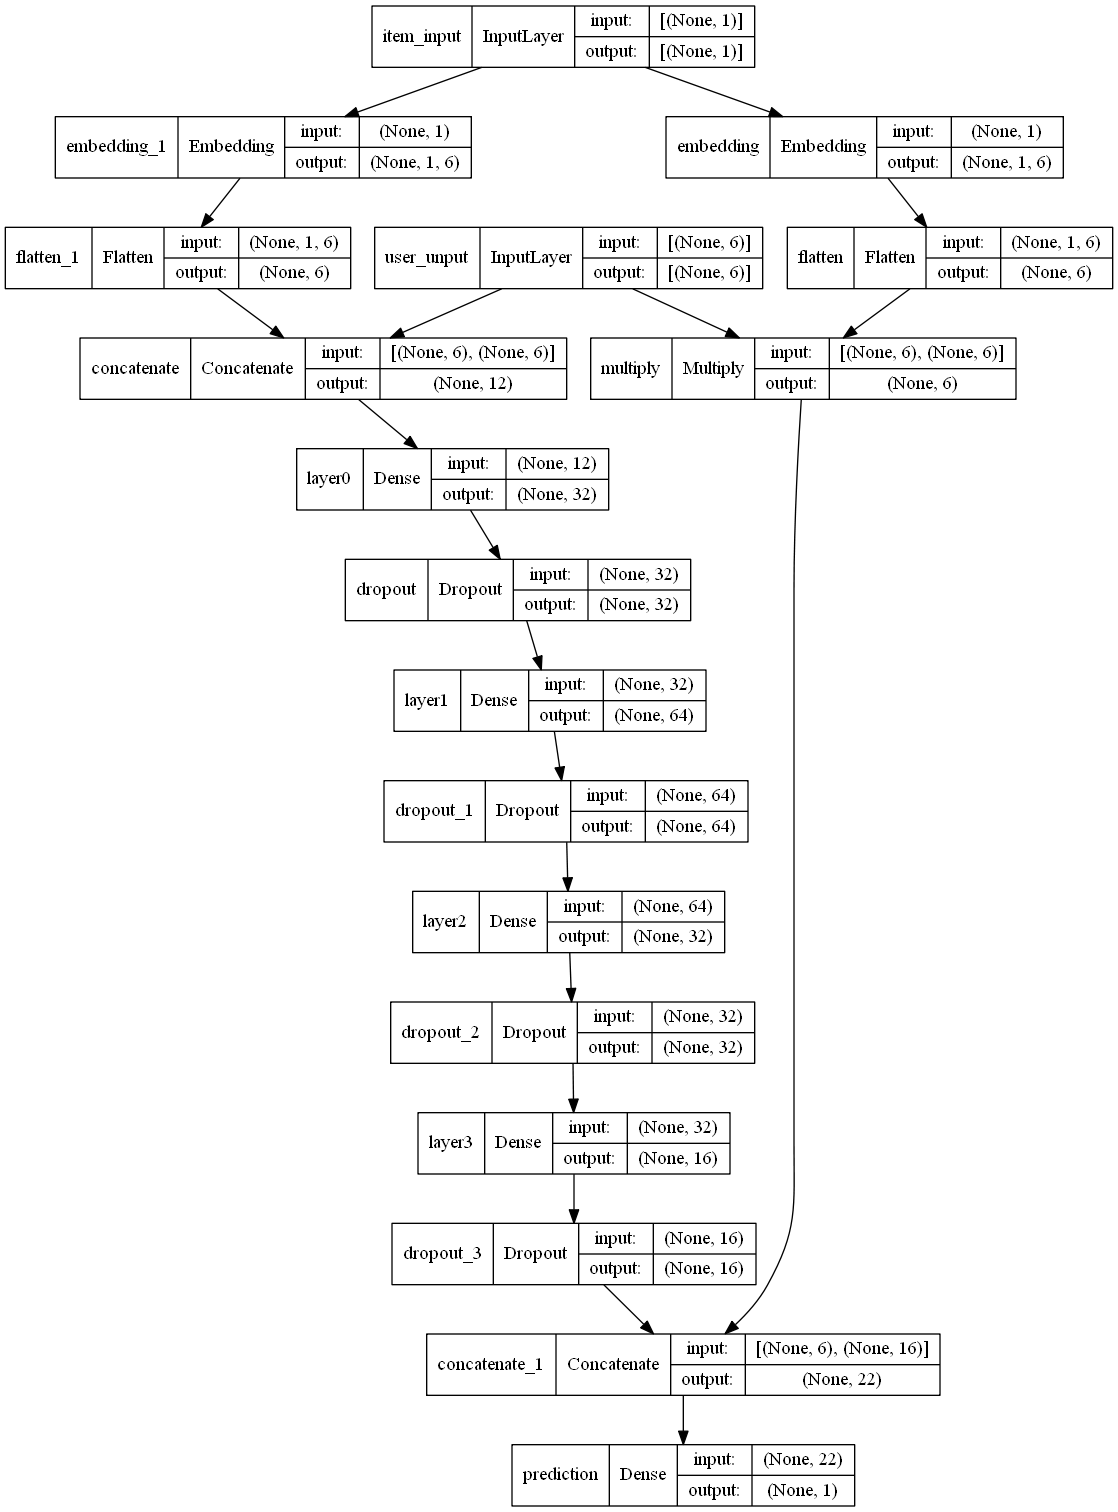

In [3]:
model = embedding_model(num_user_dataset,num_chest_dataset)
model.summary()
plot_model(model, show_shapes=True)

In [4]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)
lr = 0.0001
loss = 'binary_crossentropy'
batch_size = 128
model.compile(optimizer=Adam(learning_rate = lr), loss=loss, metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = model.fit([x_train, y_train], label_train, epochs=50, batch_size = batch_size, validation_data=([x_val, y_val], label_val),callbacks=[cb])

Epoch 1/50
9375/9375 [==============================] - 26s 3ms/step - loss: 0.3516 - precision: 0.7671 - recall: 0.5596 - auc: 0.8880 - val_loss: 0.1657 - val_precision: 0.8377 - val_recall: 0.9319 - val_auc: 0.9788
Epoch 2/50
9375/9375 [==============================] - 33s 3ms/step - loss: 0.1873 - precision: 0.8198 - recall: 0.8882 - auc: 0.9706 - val_loss: 0.1425 - val_precision: 0.8420 - val_recall: 0.9687 - val_auc: 0.9825
Epoch 3/50
9375/9375 [==============================] - 28s 3ms/step - loss: 0.1643 - precision: 0.8345 - recall: 0.9189 - auc: 0.9766 - val_loss: 0.1353 - val_precision: 0.8420 - val_recall: 0.9765 - val_auc: 0.9842
Epoch 4/50
9375/9375 [==============================] - 30s 3ms/step - loss: 0.1541 - precision: 0.8409 - recall: 0.9299 - auc: 0.9790 - val_loss: 0.1304 - val_precision: 0.8437 - val_recall: 0.9830 - val_auc: 0.9852
Epoch 5/50
9375/9375 [==============================] - 32s 3ms/step - loss: 0.1479 - precision: 0.8444 - recall: 0.9365 - auc: 0.98

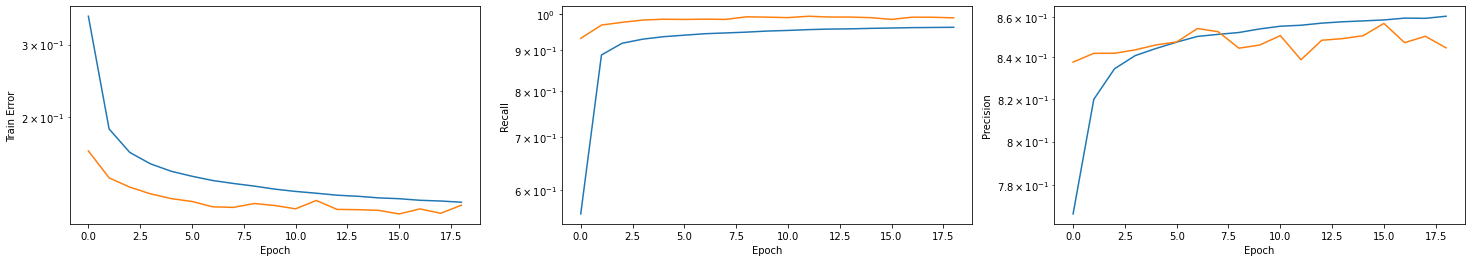

In [10]:
plt.figure(figsize=(25,4), facecolor='white')
plt.subplot(1,3,1)
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

plt.subplot(1,3,2)
pd.Series(history.history['recall']).plot(logy=True)
pd.Series(history.history['val_recall']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Recall")

plt.subplot(1,3,3)
pd.Series(history.history['precision']).plot(logy=True)
pd.Series(history.history['val_precision']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/metrics.png")
plt.show()

[[206329  13241]
 [  1226  79204]]


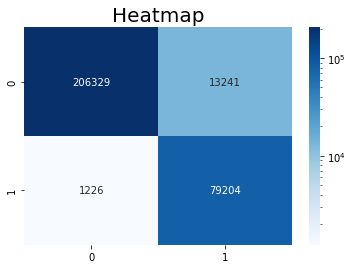

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

label_pre = model.predict([x_val, y_val])


# #Create confusion matrix and normalizes it over predicted (columns)
# label = np.argmax(label_val, axis = 1)

label_pre = np.round(label_pre,0)
result = confusion_matrix(label_val, label_pre)
print(result)

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
plt.figure(facecolor='white')
ax = sns.heatmap(result, annot=True,fmt='d',cmap='Blues',norm=LogNorm())
plt.title('Heatmap', fontsize=20)
plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/heatmap.png")
plt.show()